In [619]:
import numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
import os
# import numpy as jnp
import tqdm
from IPython.display import clear_output, display

from jax import jit, grad, vmap, jacfwd
from jax.scipy.stats import gaussian_kde as kde
from jax.scipy.stats import multivariate_normal as mvn
from jax.scipy.special import logsumexp
import jax
from functools import partial
cpu = jax.devices("cpu")[0]
try:
    gpu = jax.devices("cuda")[0]
except:
    gpu = cpu

jnp.set_printoptions(precision=4)

jax.config.update("jax_enable_x64", False)

from IPython.core.magic import register_cell_magic

import numpy as np

@register_cell_magic
def skip(line, cell):
    return

(10000, 2)


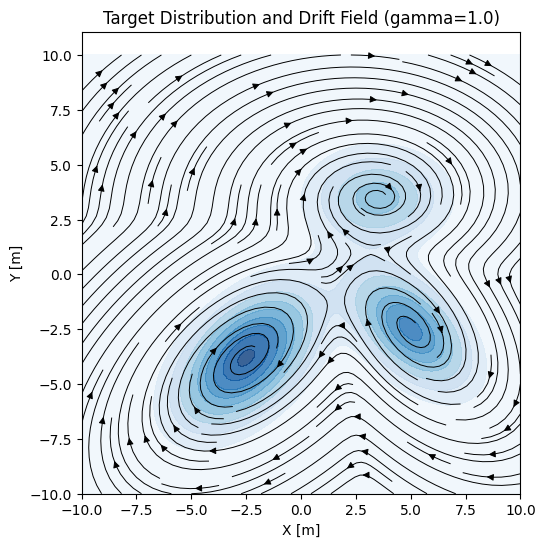

In [620]:
# Mixture params as JAX arrays
means = jnp.stack([
    jnp.array([-2.5, -3.8]),
    jnp.array([5.0, -2.5]),
    jnp.array([3.5, 3.5]),
])  # (3, 2)

covs = jnp.stack([
    jnp.array([[4.0,  2.0],
               [2.0,  4.0]]),
    jnp.array([[3.0, -1.5],
               [-1.5, 3.0]]),
    jnp.array([[4.0,  0.0],
               [0.0,  2.0]]),
])  # (3, 2, 2)


# means = jnp.stack([
#     jnp.array([-5.0, -5.0]),
#     jnp.array([5.0, -5.0]),
#     jnp.array([0.0, 5.0]),
# ])  # (3, 2)

# weights = jnp.array([0.0, 0.5, 0.5])   # sum to 1
weights = jnp.array([0.5, 0.3, 0.2])   # sum to 1
log_weights = jnp.log(weights + 1e-12)  # avoid log(0) just in case

# Precompute inverses and normalization constants
cov_inv = jnp.linalg.inv(covs)                       # (3, 2, 2)
log_det = jnp.log(jnp.linalg.det(covs))              # (3,)
d = 2
log_norm = -0.5 * (d * jnp.log(2.0 * jnp.pi) + log_det)  # (3,)

def component_logpdf(x):
    """
    x: (...,) at least 2D, we use x[:2]
    returns: (3,) log N_k(x)
    """
    z = x[:2] - means                # (3, 2)
    quad = jnp.einsum('ki,kij,kj->k', z, cov_inv, z)  # (3,)
    return log_norm - 0.5 * quad     # (3,)

def log_pdf(x):
    """
    Stable log mixture density.
    """
    log_comps = component_logpdf(x)              # (3,)
    return logsumexp(log_weights + log_comps)    # scalar

score_pdf = grad(log_pdf)
sigma = 1
D = 0.5 * (sigma**2) * jnp.eye(2)

# Skew-symmetric matrix S for circulation r = gamma * S * score
S = jnp.array([[0.0, -1.0],
              [1.0,  0.0]])  # 90° rotation

@jax.jit
def drift(x, gamma=0.0):
    s = score_pdf(x)
    r = gamma * (S @ s.T).T  # apply S to each vector
    return D @ s + r



pdf = jax.jit(lambda x: jnp.exp(log_pdf(x)))

lims = [-10, 10, -10, 10]  # x_min, x_max, y_min, y_max
map_resolution = 0.2

# Use NumPy for grid generation (better for matplotlib)
n_x = int((lims[1] - lims[0]) / map_resolution)
n_y = int((lims[3] - lims[2]) / map_resolution)

grids_x, grids_y = np.meshgrid(
    np.linspace(lims[0], lims[1], n_x),
    np.linspace(lims[2], lims[3], n_y)
)

# Convert to JAX arrays for computation
grids_jax = jnp.array(np.stack([grids_x.ravel(), grids_y.ravel()], axis=1))
pdf_grids = vmap(pdf)(grids_jax).reshape(grids_x.shape)

fs1 = vmap(lambda x: drift(x, gamma=5))(grids_jax)
print(fs1.shape)
FX1 = fs1[:, 0].reshape(grids_x.shape)
FY1 = fs1[:, 1].reshape(grids_x.shape)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal', 'box')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.contourf(grids_x, grids_y, pdf_grids, cmap='Blues', levels=10, alpha=0.8, zorder=0)
ax.streamplot(grids_x, grids_y, FX1, FY1, color='k', density=1.5, linewidth=0.7, arrowsize=1)
ax.set_title("Target Distribution and Drift Field (gamma=1.0)")
plt.show()

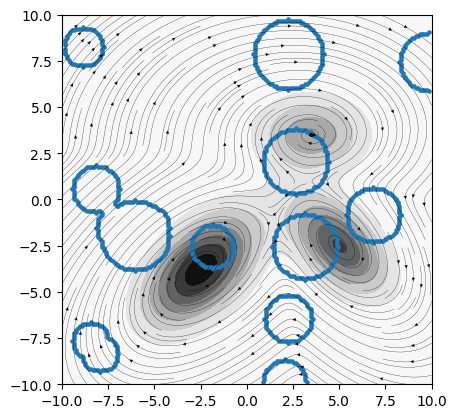

In [621]:
# Obstacle map generator
def generate_obstacle_map(
    num_obstacles: int, 
    map_size: tuple,
    obstacle_radius_range: tuple,
    map_resolution: float = 0.2,
    seed: int = 0
):
    """
    map_size: (size_x, size_y) in meters
    map_resolution: voxel size in meters
    World frame is assumed to be centered at (0, 0), so map spans
        x in [-map_size[0]/2, map_size[0]/2]
        y in [-map_size[1]/2, map_size[1]/2]
    """

    rng = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(rng)

    # Grid dimensions (rows: y, cols: x)
    nx = int(map_size[0] / map_resolution)  # number of cells along x
    ny = int(map_size[1] / map_resolution)  # number of cells along y

    # obstacle_map[row, col] = occupied?
    obstacle_map = jnp.zeros((ny, nx), dtype=bool)
    obstacles = []

    # Sample random circular obstacles (in world coordinates)
    for _ in range(num_obstacles):
        key, subkey = jax.random.split(key)
        x = jax.random.uniform(subkey, minval=-map_size[0] / 2, maxval=map_size[0] / 2)
        key, subkey = jax.random.split(key)
        y = jax.random.uniform(subkey, minval=-map_size[1] / 2, maxval=map_size[1] / 2)
        key, subkey = jax.random.split(key)
        radius = jax.random.uniform(subkey, minval=obstacle_radius_range[0], maxval=obstacle_radius_range[1])
        obstacles.append((x, y, radius))

    # Rasterize circles into the grid
    for (x, y, radius) in obstacles:
        cx = int((x + map_size[0] / 2) / map_resolution)  # col index
        cy = int((y + map_size[1] / 2) / map_resolution)  # row index
        r = int(radius / map_resolution)

        # grid indices relative to the center cell
        y_grid, x_grid = jnp.ogrid[
            -cy:ny-cy,
            -cx:nx-cx
        ]
        mask = x_grid**2 + y_grid**2 <= r**2
        obstacle_map = jnp.where(mask, True, obstacle_map)

    # ---- Vectorized perimeter extraction (4-neighborhood) ----
    occ = obstacle_map
    inner = occ[1:-1, 1:-1]

    # cell is interior if all 4 neighbors are occupied
    all_neighbors_occupied = (
        inner &
        occ[:-2, 1:-1] &  # up
        occ[2:, 1:-1] &   # down
        occ[1:-1, :-2] &  # left
        occ[1:-1, 2:]     # right
    )

    perimeter_map_full = jnp.zeros_like(occ, dtype=bool)

    # perimeter = occupied but not fully surrounded
    perimeter_inner = inner & ~all_neighbors_occupied

    # insert back into full-size map
    perimeter_map_full = jnp.zeros_like(occ, dtype=bool)
    perimeter_map_full = perimeter_map_full.at[1:-1, 1:-1].set(perimeter_inner)

    # indices of boundary cells (row, col)
    boundary_indices = jnp.argwhere(perimeter_map_full)
    # ---- Convert indices to world (x, y) coordinates ----
    if boundary_indices.size == 0:
        boundary_points = jnp.empty((0, 2), dtype=float)
    else:
        rows = boundary_indices[:, 0]  # y indices
        cols = boundary_indices[:, 1]  # x indices

        # cell centers in world coordinates
        xs = (cols + 0.5) * map_resolution - map_size[0] / 2.0
        ys = (rows + 0.5) * map_resolution - map_size[1] / 2.0

        boundary_points = jnp.stack([xs, ys], axis=-1)  # shape (N, 2)

    # Obstacle points in world coordinates
    obstacle_rows, obstacle_cols = jnp.where(obstacle_map)
    obs_xs = (obstacle_cols + 0.5) * map_resolution - map_size[0] / 2.0
    obs_ys = (obstacle_rows + 0.5) * map_resolution - map_size[1] / 2.0

    obstacle_points = jnp.stack([obs_xs, obs_ys], axis=-1)  # shape (N, 2)
    return obstacle_map, obstacle_points, obstacles, boundary_indices, boundary_points

map_size = (20.0, 20.0)
obstacle_map, obstacle_points, obstacles, boundary_indices, boundary_points = generate_obstacle_map(num_obstacles=15, 
                                  map_size=map_size,
                                  obstacle_radius_range=(1.0, 2.0),
                                  map_resolution=0.1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal', 'box')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[2], lims[3])
ax.contourf(grids_x, grids_y, pdf_grids, cmap='Greys')
ax.streamplot(np.array(grids_x), np.array(grids_y), np.array(FX1), np.array(FY1), 
              color='black', density=2, linewidth=0.2, arrowstyle='-|>', arrowsize=0.5)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='tab:blue', s=5)
plt.show()

In [622]:
class Perception():
    def __init__(self,
                 map_size: jnp.ndarray,
                 map_resolution: float,
                 range: float,
                 global_obstacle_map: jnp.ndarray = None):
        """
        Map is centered at (0, 0) in world frame.
        """
        self.map_size = map_size # Map size in meters (size_x, size_y) (considering a square map)
        self.map_resolution = map_resolution
        self.range = range

        # Assuming isometric local map
        self.local_cells = int(self.range / self.map_resolution)
        self.H = self.local_cells
        self.W = self.local_cells
        self.obstacle_local = jnp.zeros((self.H, self.W), dtype=bool)
        self.grid_shape = (
            int(map_size[1] / map_resolution),
            int(map_size[0] / map_resolution)
        ) # Grid shape (H, W)

        # Pre-compute boundary map if global map provided (static environment)
        if global_obstacle_map is not None:
            self.global_boundary_map = self._extract_boundaries(global_obstacle_map)
        else:
            self.global_boundary_map = None


    def _extract_boundaries(self, obstacle_map: jnp.ndarray) -> jnp.ndarray:
        """
        Extract obstacle boundaries using 4-neighborhood.
        Returns a boolean map where True = boundary cell.
        """
        occ = obstacle_map
        inner = occ[1:-1, 1:-1]
        
        all_neighbors_occupied = (
            inner &
            occ[:-2, 1:-1] &  # up
            occ[2:, 1:-1] &   # down
            occ[1:-1, :-2] &  # left
            occ[1:-1, 2:]     # right
        )
        
        perimeter_inner = inner & ~all_neighbors_occupied
        
        perimeter_map = jnp.zeros_like(occ, dtype=bool)
        perimeter_map = perimeter_map.at[1:-1, 1:-1].set(perimeter_inner)
        
        return perimeter_map


    def _world_to_grid(self, point_xy: jnp.ndarray) -> Tuple[int, int]:
        """
        Convert world (x, y) to grid (row, col).
        World is assumed centered in [0, 0]. If not, provide offset externally.
        """
        c = ((point_xy[0] + self.map_size[0] * 0.5) / self.map_resolution).astype(int)
        r = ((point_xy[1] + self.map_size[1] * 0.5) / self.map_resolution).astype(int)

        # # clamp
        # c = jnp.maximum(0, jnp.minimum(self.grid_shape[1] - 1, c))
        # r = jnp.maximum(0, jnp.minimum(self.grid_shape[0] - 1, r))
        return r, c


    @partial(jax.jit, static_argnums=(0,))
    def _flood_fill_reachable(self, start_rc: tuple[int, int]) -> jnp.ndarray:
        """
        obstacle_local: (H, W) bool, True = obstacle, False = free
        start_rc: (row, col) of the start cell in this local patch
        Returns:
            reachable: (H, W) bool, True where the start can reach a free cell.
        """
        H, W = self.obstacle_local.shape
        free_mask = ~self.obstacle_local  # True where we are allowed to move

        # visited and current frontier
        visited = jnp.zeros((H, W), dtype=bool)
        frontier = jnp.zeros((H, W), dtype=bool).at[start_rc].set(True)

        def cond_fun(state):
            frontier, visited = state
            return jnp.any(frontier)  # stop when there is no active frontier

        def body_fun(state):
            frontier, visited = state

            # mark current frontier as visited
            visited = visited | frontier

            # compute 4-neighbourhood of frontier
            nb = jnp.zeros_like(frontier)

            # up: pixels that have a frontier pixel below them
            nb = nb | jnp.pad(frontier[1:, :], ((0, 1), (0, 0)))
            # down
            nb = nb | jnp.pad(frontier[:-1, :], ((1, 0), (0, 0)))
            # left
            nb = nb | jnp.pad(frontier[:, 1:], ((0, 0), (0, 1)))
            # right
            nb = nb | jnp.pad(frontier[:, :-1], ((0, 0), (1, 0)))

            # only keep free, not-yet-visited cells
            new_frontier = nb & free_mask & (~visited)
            return (new_frontier, visited)

        frontier, visited = jax.lax.while_loop(cond_fun, body_fun, (frontier, visited))
        reachable = visited & free_mask  # we only care about free reachable cells
        return reachable

    # @partial(jax.jit, static_argnums=(0,))
    def occupancy(self,
                obstacle_map: jnp.ndarray,
                position: jnp.ndarray):
        """
        Build local tri-state occupancy grid around 'position'.

        - Local grid is always H×W, centered on the robot.
        - Cells that map outside the global map are treated as UNKNOWN (0.5).
        """
        # Choose which global map we use
        if self.global_boundary_map is not None:
            boundary_map = self.global_boundary_map
        elif obstacle_map is not None:
            boundary_map = obstacle_map  # already boundary map
        else:
            raise ValueError("Must provide obstacle_map or initialize with global_obstacle_map")

        H_glob, W_glob = boundary_map.shape

        # Robot index in global grid (UNCLAMPED)
        row, col = self._world_to_grid(position)

        # Local window size (fixed, from __init__)
        local_H = self.H
        local_W = self.W
        half_H = local_H // 2
        half_W = local_W // 2

        # Offsets around the robot
        # local indices i,j -> global_row = row + (i - half_H), etc.
        local_rows = jnp.arange(local_H)
        local_cols = jnp.arange(local_W)

        global_rows = row + (local_rows - half_H)[:, None]   # (H,1) -> (H,W)
        global_cols = col + (local_cols - half_W)[None, :]   # (1,W) -> (H,W)

        # Valid cells: inside the global map
        valid = (
            (global_rows >= 0) & (global_rows < H_glob) &
            (global_cols >= 0) & (global_cols < W_glob)
        )

        # For indexing, clamp to valid range, but we'll mask later
        global_rows_clamped = jnp.clip(global_rows, 0, H_glob - 1)
        global_cols_clamped = jnp.clip(global_cols, 0, W_glob - 1)

        # Gather global obstacles into local patch
        obstacle_local_raw = boundary_map[global_rows_clamped, global_cols_clamped]

        # Outside-global-map cells are treated as "no obstacle info"
        obstacle_local = jnp.where(valid, obstacle_local_raw, False)

        # Robot index in local patch is always the center
        start_rc = (half_H, half_W)

        # ---- tri-state occupancy ----
        occupancy_state = jnp.full((local_H, local_W), 0.5, dtype=jnp.float32)

        # Flood fill on this local patch (reachable free cells)
        self.obstacle_local = obstacle_local

        # If the robot is completely outside the global map, center is invalid → no reachable
        center_valid = valid[half_H, half_W]

        def _reachable_when_valid(_):
            return self._flood_fill_reachable(start_rc)

        reachable = jax.lax.cond(
            center_valid,
            _reachable_when_valid,
            lambda _: jnp.zeros_like(obstacle_local, dtype=bool),
            operand=None,
        )

        occupancy_state = jnp.where(obstacle_local, 0.0, occupancy_state)
        occupancy_state = jnp.where(reachable, 1.0, occupancy_state)

        # ---- world coordinates for local grid ----
        # (you can decide whether to use unclamped or clamped indices here;
        # unclamped shows the "true" positions beyond the map_size box)
        x_coords = (global_cols + 0.5) * self.map_resolution - self.map_size[0] / 2.0
        y_coords = (global_rows + 0.5) * self.map_resolution - self.map_size[1] / 2.0
        world_points = jnp.array([x_coords, y_coords]).T  # shape (H, W, 2)
        print(world_points.shape)
        return occupancy_state, world_points

In [623]:
# Define function to calculate Stein variational gradient (RBF kernel)
@jax.jit
def kernel(x1, x2, h):
    # same as in the pdf function, only evaluate the first two dimensions
    """
    Here h is the bandwidth parameter for the RBF kernel
    """
    return jnp.exp(-1.0 * jnp.sum(jnp.square(x1[:2]-x2[:2])) / h)


d_kernel = jax.grad(kernel, argnums=(0)) # This is needed for the Stein operator


@jax.jit
def stein_grad_unit(x1, x2, h):
    val = kernel(x2, x1, h) * drift(x2, gamma=0.5) + d_kernel(x2, x1, h)
    return val


@jax.jit
def stein_grad_state(x, x_traj, h):
    """
    Here we compute the Stein gradient for a single particle x against all particles in x_traj
    and then average the results.
    The vmap has in_axes=(None, 0, None) because we want to keep x fixed and vary x_traj
    over its first axis (the particles).
    """
    vals = jax.vmap(stein_grad_unit, in_axes=(None, 0, None))(x, x_traj, h)
    return jnp.mean(vals, axis=0)

@jax.jit
def stein_grad(traj, h):
    """
    Here we vmap over all particles in traj to compute their Stein gradients.
    """
    return jax.vmap(stein_grad_state, in_axes=(0, None, None))(traj, traj, h)

stein_grad = jax.jit(stein_grad, device=gpu)

In [ ]:
class MPPIController():
    def __init__(
            self,
            delta_t: float = 0.05,
            max_steer_abs: float = 0.523,
            max_accel_abs: float = 2.000,
            horizon_step_T: int = 30,
            number_of_samples_K: int = 1000,
            param_exploration: float = 0.0,
            param_lambda: float = 50.0,
            param_alpha: float = 1.0,
            param_flow_alpha: float = 1,
            sigma: jnp.ndarray = jnp.array([[0.5, 0.0], [0.0, 0.1]]),
            stage_cost_weights: jnp.ndarray = jnp.array([50.0, 50.0]),
            terminal_cost_weights: jnp.ndarray = jnp.array([50.0, 50.0, 1.0, 20.0]),
            v_ref: float = 3.0,
            wheel_base: float = 2.5,
            use_gpu: bool = True,
            map_resolution: float = 0.2,
            sensing_range: float = 2.0,
            safety_distance: float = 1.0,
            min_safety_distance: float = 0.1,
            occupancy_points: jnp.ndarray = None,
            collision_cost: float = 100.0,
            sensing_cost: float = 1.0,
            oom_cost: float = 10.0,
            seed: int = 0,
    ) -> None:
        devices = jax.devices("gpu" if use_gpu and jax.devices("gpu") else "cpu")
        self.device = devices[0]
        print(f"[INFO] Using device: {self.device}")
        with jax.default_device(self.device):
            self.dim_x = 4 
            self.dim_u = 2
            self.T = horizon_step_T
            self.K = number_of_samples_K
            self.param_exploration = param_exploration
            self.param_lambda = param_lambda
            self.param_alpha = param_alpha
            self.param_gamma = self.param_lambda * (1.0 - (self.param_alpha))
            self.Sigma = sigma
            # self.Sigma_inv = jnp.linalg.inv(self.Sigma)
            self.Sigma_inv = jnp.linalg.cholesky(self.Sigma + 1e-8 * jnp.eye(self.dim_u))
            self.stage_cost_weights = stage_cost_weights
            self.terminal_cost_weights = terminal_cost_weights
            self.v_ref = v_ref
            self.flow_alpha = param_flow_alpha
            self.collision_cost = collision_cost
            self.sensing_cost = sensing_cost
            self.oom_cost = oom_cost

            # vehicle parameters
            self.delta_t = delta_t #[s]
            self.max_steer_abs = max_steer_abs # [rad]
            self.max_accel_abs = max_accel_abs # [m/s^2]
            self.wheel_base = wheel_base # [m]
            self.sensing_range = sensing_range  # [m]
            self.safety_distance = safety_distance  # [m] DESIRED safety distance
            self.min_safety_distance = min_safety_distance  # [m] MINIMUM safety distance, collision if below
            # Filter
            self.window_size = 10
            kernel_1d = jnp.ones((self.window_size,), dtype=jnp.float32) / self.window_size
            self.ma_kernel = jnp.tile(kernel_1d[None, None, :], (self.dim_u, 1, 1))  # (dim_u, 1, w)

            # Stochasticity params
            self.key = jax.random.PRNGKey(seed)

            self.u_prev = jnp.zeros((self.T, self.dim_u))

            # Safety checks
            if self.Sigma.shape[0] != self.Sigma.shape[1] \
                or self.Sigma.shape[0] != self.dim_u \
                or self.dim_u < 1:
                raise ValueError("[ERROR] Sigma must be (size_dim_u x size_dim_u).")
            
            # Map related

            self.occupancy_points = occupancy_points
            self.map_resolution = map_resolution
            self.map_size = jnp.array([self.occupancy_points.shape[0] * self.map_resolution,
                                       self.occupancy_points.shape[1] * self.map_resolution])
            self.map_x_limits = jnp.array([-self.map_size[0]/2, self.map_size[0]/2])
            self.map_y_limits = jnp.array([-self.map_size[1]/2, self.map_size[1]/2])

            # Perception-related
            # self.percep = Perception(
            #     map_size=self.map_size,
            #     map_resolution=self.map_resolution,
            #     range=self.sensing_range,
            #     global_obstacle_map=self.obstacle_map
            # )


    @partial(jax.jit, static_argnames=("self",))
    def _mppi_step(self, x0, U_prev, occupancy_points, key):
        self.current_state = x0

        # 1) sample epsilon
        key, subkey = jax.random.split(key)

        epsilon = jax.random.multivariate_normal(
            key=subkey,
            mean=jnp.zeros(self.dim_u),
            cov=self.Sigma,
            shape=(self.K, self.T),
        )  # (K, T, dim_u)

        # 2) rollouts
        num_exloration = int((1.0 - self.param_exploration) * self.K)
        use_nominal = jnp.arange(self.K) < num_exloration

        S_V = jax.vmap(self.single_rollout, in_axes=(None, None, 0, 0, None), out_axes=(0, 0, 0))
        S, V, trajs = S_V(x0, U_prev, epsilon, use_nominal, occupancy_points) # S: (K,); V: (K, T, dim_u); trajs: (K, T, dim_x)

        # 3) Flow matching: compute Stein gradient on spatial positions only
        spatial_trajs = trajs[:, :, :2]  # Extract (x, y) positions: (K, T, 2)
        spatial_mean = jnp.median(spatial_trajs, axis=0)  # (T, 2)
        h_target = stein_grad(spatial_mean, h=1.0)  # (T, 2) - Stein gradient for spatial positions

        # Align shapes: compare spatial_trajs (K, T, 2) with h_target (T, 2)
        # Deviation from target flow in spatial dimensions only
        S_flow = -jnp.einsum('ktn,tn->k', spatial_trajs, h_target)  # (K,)
        S = S + self.flow_alpha * S_flow

        # 3) update controls
        U = self.update_controls(U_prev, S, V)

        # 4) trajectories
        optimal_traj = self._optimal_trajectory(x0, U)

        # 5) shift control sequence
        U_prev_next = jnp.roll(U, shift=-1, axis=0).at[-1].set(U[-1])

        return U[0], U, optimal_traj, trajs, epsilon, key, U_prev_next


    def calc_control_input(self, x0: jnp.ndarray):
        # x0 should already be on the right device, or you can device_put here
        u0, U, optimal_traj, sampled_traj_list, epsilon, key_new, U_prev_next= \
            self._mppi_step(x0, self.u_prev, self.occupancy_points, self.key)

        # update mutable fields outside jit
        self.key = key_new
        self.u_prev = U_prev_next

        return u0, U, optimal_traj, sampled_traj_list, epsilon


    @partial(jax.jit, static_argnames=("self",))
    def single_rollout(self, 
                       x0: jnp.ndarray, 
                       U: jnp.ndarray, 
                       epsilon: jnp.ndarray,
                       use_nominal: bool,
                       occupancy_points: jnp.ndarray) -> jnp.ndarray:
        """
        Perform a single rollout of the system dynamics given initial state, 
        control sequence, and noise.
        :param x0: (dim_x,) Initial state
        :param U: (T_horizon, dim_u) Control sequence
        :param epsilon: (T_horizon, dim_u) Noise sequence
        :return: S: (,) Cumulative cost of the rollout
        """
        def step(carry, inputs):
            x, S = carry
            U_t, epsilon_t = inputs
            v_t = jnp.where(use_nominal, U_t + epsilon_t, epsilon_t)
            u_t_clamped = self._g(v_t)

            cross = self.param_gamma * (U_t @ self.Sigma_inv @ v_t)
            S = S + self._c(x, u_t_clamped, occupancy_points) + cross

            x = self._F(x, u_t_clamped)
            return (x, S), (u_t_clamped, x)

        (x, S), (V, traj) = jax.lax.scan(step, 
                                 (x0, jnp.array(0.0)),
                                 (U, epsilon))

        S = S + self._phi(x, V[-1])
        return S, V, traj


    @partial(jax.jit, static_argnames=("self",))
    def update_controls(self, U, S, V):
        rho = jnp.min(S)
        scaled = (S - rho) / self.param_lambda
        weights_unnorm = jnp.exp(-scaled)
        eta = jnp.sum(weights_unnorm)
        w = weights_unnorm / eta

        deltas = V - U[None, :, :] # (K, T, dim_u)
        w_eps = jnp.einsum('k,ktu->tu', w, deltas) # (T, dim_u)
        # w_eps = self.moving_average(w_eps)
        U_new = U + w_eps
        return U_new


    @partial(jax.jit, static_argnames=("self",))
    def _optimal_trajectory(self, x0: jnp.ndarray, U: jnp.ndarray) -> jnp.ndarray:
        """Compute optimal trajectory given initial state and control sequence."""
        def step(x, u):
            x_next = self._F(x, self._g(u))
            return x_next, x_next

        _, traj = jax.lax.scan(step, x0, U)
        return traj


    def _g(self, v: jnp.ndarray) -> jnp.ndarray:
        """clamp input: u = [accel, steer] - JAX-compatible version"""
        v_clamped = jnp.array([
            jnp.clip(v[0], -self.max_accel_abs, self.max_accel_abs),
            jnp.clip(v[1], -self.max_steer_abs, self.max_steer_abs)
        ])
        return v_clamped


    @partial(jax.jit, static_argnames=("self",))
    def safety_costs(self, x_t: jnp.ndarray, occupancy_points: jnp.ndarray) -> float:
        """
        Safety cost for a single state x_t = [x, y, yaw, v].
        
        - Distance-based cost w.r.t. occupied cells (0.0 in occupancy_map)
        - Soft penalty when outside sensing range
        """
        x, y, yaw, v = x_t
        pos = jnp.array([x, y])
        

        # Compute all distances at once
        diffs = occupancy_points - pos  # (H, W, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)  # (H, W)
        
        min_dist = jnp.min(dists)
        
        # Three-way cost: collision (min_dist < min_safety), 
        # safe (min_dist > safety), or transition zone
        below_min = min_dist <= self.min_safety_distance
        above_safe = min_dist >= self.safety_distance
        
        # Compute safety cost (only applies in transition zone)
        safety_cost = self.sensing_cost * ((min_dist - self.safety_distance) ** -1) ** 2
        
        # Select appropriate cost
        obstacle_cost = jnp.where(
            below_min,
            self.collision_cost,  # Collision
            jnp.where(above_safe, 0.0, safety_cost)  # Safe or transition
        )
        
        # # Only apply if obstacles exist
        # obstacle_cost = jnp.where(True, obstacle_cost, 0.0)
        
        # ---------- Sensing range penalty ----------
        dist_from_robot = jnp.linalg.norm(pos - self.current_state[:2])
        range_cost = jnp.where(
            dist_from_robot <= self.sensing_range,
            0.0,
            self.sensing_cost * (dist_from_robot - self.sensing_range) ** 2
        )
        
        return obstacle_cost + range_cost


    def _c(self, x_t: jnp.ndarray, u_t: jnp.ndarray, occupancy_points: jnp.ndarray) -> float:
        """
        Instantaneous running cost for a single state/control pair.
        """
        accel, steer = u_t
        x, y, yaw, v = x_t

        w_accel = self.stage_cost_weights[0]
        w_steer = self.stage_cost_weights[1]

        # safety cost (from obstacles + sensing range)
        safety_cost = 0.0 # self.safety_costs(x_t, occupancy_points)
        # out-of-bounds penalty (JAX-friendly, no Python ifs)
        out_x_low  = x < self.map_x_limits[0]
        out_x_high = x > self.map_x_limits[1]
        out_y_low  = y < self.map_y_limits[0]
        out_y_high = y > self.map_y_limits[1]

        out_of_bounds = out_x_low | out_x_high | out_y_low | out_y_high
        out_of_bounds_cost = jnp.where(out_of_bounds, self.oom_cost, 0.0)

        return (
            w_accel * accel**2 +
            w_steer * steer**2 +
            safety_cost +
            out_of_bounds_cost
        )


    @partial(jax.jit, static_argnames=("self",))
    def _phi(self, x_T, u_T: jnp.ndarray) -> float:
        """Terminal cost: penalize out-of-bounds states."""
        x, y, yaw, v = x_T
        
        # Check boundary violations using JAX-compatible comparisons
        out_x = (x < self.map_x_limits[0]) | (x > self.map_x_limits[1])
        out_y = (y < self.map_y_limits[0]) | (y > self.map_y_limits[1])
        
        # Compute cost: 100.0 for each violated dimension
        cost_x = jnp.where(out_x, self.oom_cost, 0.0)
        cost_y = jnp.where(out_y, self.oom_cost, 0.0)
        
        return 0.0


    def _F(self, x_t: jnp.ndarray, v_t: jnp.ndarray) -> jnp.ndarray:
        """calculate next state of the vehicle"""
        # get previous state variables
        x, y, yaw, v = x_t
        accel, steer = v_t

        # prepare params
        l = self.wheel_base
        dt = self.delta_t

        # update state variables
        new_x = x + v * jnp.cos(yaw) * dt
        new_y = y + v * jnp.sin(yaw) * dt
        new_yaw = yaw + v / l * jnp.tan(steer) * dt
        new_v = v + accel * dt

        # return updated state
        x_t_plus_1 = jnp.array([new_x, new_y, new_yaw, new_v])
        return x_t_plus_1


    @partial(jax.jit, static_argnames=("self",))
    def moving_average(self, xx: jnp.ndarray) -> jnp.ndarray:
        T, dim = xx.shape
        xx_ncl = jnp.swapaxes(xx, 0, 1)[None, :, :]  # (1, dim, T)

        yy_ncl = jax.lax.conv_general_dilated(
            lhs=xx_ncl,
            rhs=self.ma_kernel,
            window_strides=(1,),
            padding="SAME",
            dimension_numbers=("NCL", "OIL", "NCL"),
            feature_group_count=dim,
        )
        yy = jnp.swapaxes(yy_ncl[0], 0, 1)
        return yy


In [625]:
@jax.jit
def batch_stats(X):
    m = jnp.mean(X, axis=0) # (T_states, n)
    return m


@jax.jit
def reinforce_Gm_naive(X, mean, eps, Sigma):
    """
    Sensitivity of mean state to control perturbations.
    :param X: (N, T_states, n) Trajectories
    :param mean: (T_states, n) Mean trajectory
    :param eps: (N, T_controls, d) Noise sampled
    :param Sigma: (d, d) Covariance matrix of noise
    :return: Gm (T_states, T_controls, n, d) Sensitivity matrix
    """
    T_states = X.shape[1]
    T_controls = eps.shape[1]
    n = X.shape[2]
    d = eps.shape[2]
    G_m = jnp.zeros((T_states, T_controls, n, d))
    Sigma_inv = jnp.linalg.inv(Sigma + 1e-8 * jnp.eye(d))
    scores = eps @ Sigma_inv.T  # (N, T, d)
    for t_s in range(T_states):
        for t_c in range(T_controls):
            if t_s <= t_c:
                continue
            sum_ = jnp.zeros((n, d))
            for b in range(X.shape[0]):
                dx = X[b, t_s] - mean[t_s]
                score =  scores[b, t_c]
                sum_ += jnp.outer(dx, score)
            G_m = G_m.at[t_s, t_c].set(sum_ / X.shape[0])
    return G_m

@jax.jit
def reinforce_Gm(X, mean, eps, Sigma):
    """
    Sensitivity of mean state to control perturbations.
    :param X: (N, T_states, n) Trajectories
    :param mean: (T_states, n) Mean trajectory
    :param eps: (N, T_controls, d) Noise sampled
    :param Sigma: (d, d) Covariance matrix of noise
    :return: Gm (T_states, T_controls, n, d) Sensitivity matrix
    """
    N, T_states, n = X.shape
    T_controls, d = eps.shape[1], eps.shape[2]
    Sigma_inv = jnp.linalg.cholesky(Sigma + 1e-6 * jnp.eye(d))

    # Center states with broadcasting
    X_centered = X - mean[None, :, :]  # (N, T, n)
    score = jnp.einsum('ij,btj->bti', Sigma_inv, eps)  # (N, T, d)
    
    # Raw REINFORCE map (without causality):
    # (T_states, T_controls, n, d)
    G_raw = jnp.einsum('btn,bkd->tknd', X_centered, score) / N
    print("X_centered:", X_centered)
    # Causality mask: u_k only affects x_t for t > k
    causal_mask = jnp.tril(jnp.ones((T_states, T_controls)), k=-1)
    G_m = G_raw * causal_mask[:, :, None, None]
    return G_m


@jax.jit
def control_flow_naive(mean, Gm):
    """
    :param mean: (T_states, n) Mean trajectory
    :param Gm: (T_states, T_controls, n, d) Sensitivity matrix
    :return: v (T_controls, d) Control perturbation
    """
    T_states = mean.shape[0]
    T_controls = Gm.shape[1]
    d = Gm.shape[3]
    v = jnp.zeros((T_controls, d))
    for k in range(T_controls):
        sum_ = jnp.zeros((d,))
        for t in range(T_states):
            stein_term = stein_grad(mean[t], mean, h=0.08) # (n,)
            Gm_t = Gm[t, k].T # (d, n)
            sum_ += Gm_t @ stein_term
        v = v.at[k].set(sum_)
    return v


@jax.jit
def control_flow(mean, Gm):
    """
    Control flow computation using Stein gradients.
    :param mean: (T_states, n) Mean trajectory
    :param Gm: (T_states, T_controls, n, d) Sensitivity matrix
    :return: v (T_controls, d) Control perturbation
    """
    T_controls = Gm.shape[1]
    d = Gm.shape[3]
    v = jnp.zeros((T_controls, d))

    stein_terms = stein_grad(mean, h=10)
    print("Stein terms:", stein_terms)
    v = jnp.einsum('tknd,tn->kd', Gm, stein_terms)
    return v


In [ ]:
lims = [-10, 10, -10, 10] # x_min, x_max, y_min, y_max
delta_t = 0.01
WB = 0.1

Sigma_u = jnp.diag(jnp.array([1**2, jnp.deg2rad(8.0)**2]))
map_size = (20.0, 20.0)

obstacle_map, obstacle_points, obstacles, boundary_indices, boundary_points = generate_obstacle_map(num_obstacles=25, 
                                  map_size=map_size,
                                  obstacle_radius_range=(0.5, 1),
                                  seed=42)

grids_x, grids_y = jnp.meshgrid(
    jnp.linspace(lims[0], lims[1], 100),
    jnp.linspace(lims[2], lims[3], 100)
)
grids = jnp.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_grids = vmap(pdf)(grids).reshape(grids_x.shape)

params = {
    "delta_t": delta_t,
    "WB": WB,
    "Sigma_u": Sigma_u,
    "max_steer_abs": jnp.deg2rad(75.0),
    "max_accel_abs": 3.0,
    "horizon_step_T": 30,
    "number_of_samples_K": 500,
    "param_exploration": 0.1,
    "param_lambda": 1,
    "param_alpha": 0.1,
    "param_flow_alpha": 20,
}

mppi = MPPIController(
    delta_t=params["delta_t"],
    max_steer_abs=params["max_steer_abs"],
    max_accel_abs=params["max_accel_abs"],
    horizon_step_T=params["horizon_step_T"],
    number_of_samples_K=params["number_of_samples_K"],
    param_exploration=params["param_exploration"],
    param_lambda=params["param_lambda"],
    param_alpha=params["param_alpha"],
    param_flow_alpha=params["param_flow_alpha"],
    sigma=params["Sigma_u"],
    stage_cost_weights = jnp.array([0.1 ,0.1]),
    terminal_cost_weights = jnp.array([10., 10., 0.2, 0.2]),
    use_gpu=True,
    map_resolution=0.2,
    sensing_range=10.0,
    safety_distance=0.5,
    min_safety_distance=0.1,
    occupancy_points=jnp.array(obstacle_points),
    collision_cost=0.0,
    sensing_cost=0.0,
    oom_cost=0.1,
    seed=0,
)

x0 = jnp.array([-2.5, 0.0, jnp.deg2rad(0.0), 4])  # initial state

steps = 2000
plot_steps = 1

history = []
optimal_traj_segments = []
sampled_traj_segments = []

for k in tqdm.trange(steps):
    optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list, epsilon = mppi.calc_control_input(x0=x0)

    # store current state position (on host)
    history.append(np.array(x0[:2]))

    # only save full optimal trajectory every 'plot_steps' iterations
    if k % plot_steps == 0:
        optimal_traj_segments.append(np.array(optimal_traj[:, :2]))
        sampled_traj_segments.append(np.array(sampled_traj_list))

    # advance the state
    x0 = optimal_traj[1]

# convert to arrays once at the end
history = np.stack(history, axis=0)  # (steps, 2)
# New axis for segments
optimal_traj_plot = np.stack(optimal_traj_segments, axis=0)  # (num_segments, T, 2)
sampled_traj_stack = np.stack(sampled_traj_segments, axis=0)  # (num_segments, K, T, 4)

print("Simulation complete.")
print(history.shape)
print(optimal_traj_plot.shape)
print(sampled_traj_stack.shape)


[INFO] Using device: cuda:0


100%|██████████| 2000/2000 [00:07<00:00, 274.17it/s]


Simulation complete.
(2000, 2)
(2000, 30, 2)
(2000, 500, 30, 4)


(500, 30, 4)


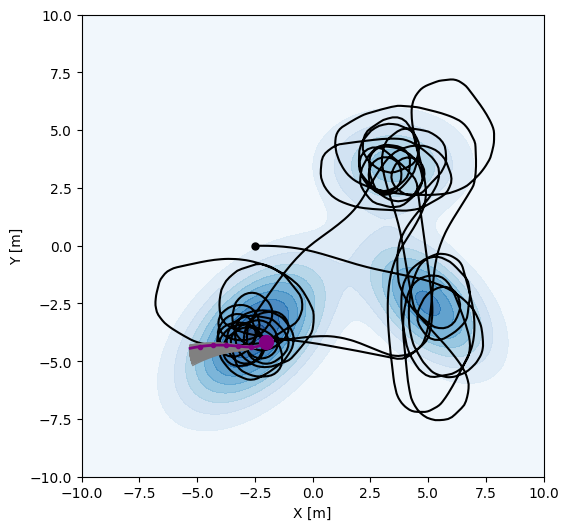

In [630]:
step_to_plot = steps -1

# Check availability
if step_to_plot % plot_steps != 0:
    raise ValueError(f"step_to_plot {step_to_plot} is not available; must be multiple of plot_steps {plot_steps}.")

optimal_traj_plot = optimal_traj_segments[step_to_plot // plot_steps]
sampled_traj_plot = sampled_traj_stack[step_to_plot // plot_steps]
print(sampled_traj_plot.shape)
history_plot = history[:step_to_plot+1]
pos = history_plot[-1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal', 'box')
# ax.set_xlim(lims[0], lims[1])
# ax.set_ylim(lims[2], lims[3])
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.contourf(grids_x, grids_y, pdf_grids, cmap='Blues', levels=10, alpha=0.8, zorder=0)

for k in range(sampled_traj_plot.shape[0]):
    if k >= int((1.0 - params["param_exploration"]) * params["number_of_samples_K"]):
        continue
    ax.plot(sampled_traj_plot[k,:, 0], sampled_traj_plot[k,:, 1], color='gray', alpha=1, zorder=9, linewidth=1)

ax.plot(optimal_traj_plot[:,0], optimal_traj_plot[:,1], color='purple',linewidth=2, zorder=10, marker='o', markersize=3, markevery=5)
ax.plot(history_plot[:,0], history_plot[:,1], 'k', linewidth=1.5)
ax.scatter(pos[0], pos[1], color='purple', s=100, zorder=10)
ax.scatter(history_plot[0,0], history_plot[0,1], color='black', s=25, zorder=10)

# ax.streamplot(np.array(grids_x), np.array(grids_y), np.array(FX1), np.array(FY1), 
#               color='black', density=2, linewidth=0.2, arrowstyle='-|>', arrowsize=0.5)
file_name = time.strftime("mppi_stein_flow_%Y%m%d-%H%M%S")
plt.savefig(f"{file_name}.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


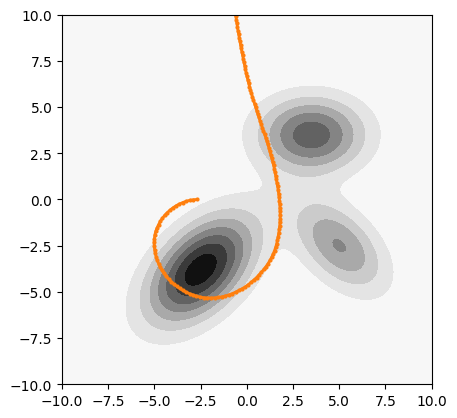

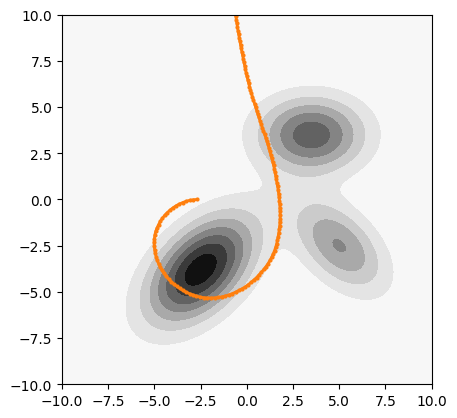

In [ ]:
"""
Act directly on the control inputs mean
"""
grids_x, grids_y = jnp.meshgrid(
    jnp.linspace(lims[0], lims[1], 100),
    jnp.linspace(lims[2], lims[3], 100)
)
grids = jnp.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_grids = vmap(pdf)(grids).reshape(grids_x.shape)

mean = batch_stats(sampled_traj_list)
# Sensitivity matrix
Gm = reinforce_Gm(sampled_traj_list, mean, epsilon, Sigma_u)
# Control flow
v = control_flow(mean, Gm)

flow_steps = 300
eta = 0.001
optimal_input_flow = optimal_input_sequence.copy()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
key_new = mppi.key
for step in range(flow_steps):
    optimal_input_flow = optimal_input_flow + eta * v
    traj = mppi._optimal_trajectory(x0, optimal_input_flow)
    ax.clear()
    ax.set_aspect('equal', 'box')
    ax.set_xlim(lims[0], lims[1])
    ax.set_ylim(lims[2], lims[3])
    ax.contourf(grids_x, grids_y, pdf_grids, cmap='Greys')
    ax.plot(traj[:,0], traj[:,1], color='C1', linewidth=2, label='Optimal Traj', marker='o', markersize=2)
    time.sleep(0.01)
    clear_output(wait=True)
    display(fig)
    u0, U, optimal_traj, sampled_traj_list, epsilon, key_new, U_prev_next = \
    mppi._mppi_step(x0, optimal_input_flow, key_new)

    mean = batch_stats(sampled_traj_list)
    # Sensitivity matrix
    Gm = reinforce_Gm(sampled_traj_list, mean, epsilon, Sigma_u)
    # Control flow
    v = control_flow(mean, Gm)
